In [27]:
import pandas as pd
import numpy as np
import pickle
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup
from pathlib import Path
from tqdm import tqdm
import datetime
import warnings
warnings.filterwarnings('ignore')

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
print(f"PyTorch version: {torch.__version__}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("✓ Libraries imported successfully!")

Device: cuda
PyTorch version: 2.9.0+cu126
✓ Libraries imported successfully!


In [28]:
# %%
print("="*60)
print("LOADING PREPROCESSED DATA")
print("="*60)

# Load preprocessed datasets
data_dir = Path('/content/sample_data')

with open(data_dir / 'train_dataset.pkl', 'rb') as f:
    train_dataset = pickle.load(f)
print(f"✓ Loaded train_dataset: {len(train_dataset['labels'])} samples")

with open(data_dir / 'val_dataset.pkl', 'rb') as f:
    val_dataset = pickle.load(f)
print(f"✓ Loaded val_dataset: {len(val_dataset['labels'])} samples")

with open(data_dir / 'test_dataset.pkl', 'rb') as f:
    test_dataset = pickle.load(f)
print(f"✓ Loaded test_dataset: {len(test_dataset['labels'])} samples")

with open(data_dir / 'class_weights.pkl', 'rb') as f:
    class_weights = pickle.load(f)
print(f"✓ Loaded class_weights")

with open(data_dir / 'config.pkl', 'rb') as f:
    config = pickle.load(f)
print(f"✓ Loaded config")

print("\nConfiguration:")
print(f"  Model: {config['model_name']}")
print(f"  Max length: {config['max_length']}")
print(f"  Number of classes: {config['num_classes']}")

print("\nClass weights:")
for cls, weight in class_weights.items():
    print(f"  Class {cls}: {weight:.4f}")

LOADING PREPROCESSED DATA
✓ Loaded train_dataset: 2324 samples
✓ Loaded val_dataset: 582 samples
✓ Loaded test_dataset: 132 samples
✓ Loaded class_weights
✓ Loaded config

Configuration:
  Model: SZTAKI-HLT/hubert-base-cc
  Max length: 256
  Number of classes: 5

Class weights:
  Class 1: 4.4030
  Class 2: 1.8277
  Class 3: 0.9167
  Class 4: 0.6283
  Class 5: 0.6479


In [29]:
# %%
print("="*60)
print("CREATING PYTORCH DATASETS AND DATALOADERS")
print("="*60)

class ASZFDataset(Dataset):
    """PyTorch Dataset for ÁSZF readability classification"""

    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings['labels'])

    def __getitem__(self, idx):
        item = {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx], dtype=torch.long),
            'labels': torch.tensor(self.encodings['labels'][idx] - 1, dtype=torch.long)  # Convert to 0-4
        }
        return item

# Create datasets
train_torch_dataset = ASZFDataset(train_dataset)
val_torch_dataset = ASZFDataset(val_dataset)
test_torch_dataset = ASZFDataset(test_dataset)

print(f"✓ Created PyTorch datasets")
print(f"  Train: {len(train_torch_dataset)} samples")
print(f"  Val:   {len(val_torch_dataset)} samples")
print(f"  Test:  {len(test_torch_dataset)} samples")

# Training hyperparameters
BATCH_SIZE = 8
LEARNING_RATE = 2e-5
NUM_EPOCHS = 5

print(f"\nHyperparameters:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Number of epochs: {NUM_EPOCHS}")

# Create DataLoaders
train_loader = DataLoader(
    train_torch_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    val_torch_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loader = DataLoader(
    test_torch_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"\n✓ Created DataLoaders")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches:   {len(val_loader)}")
print(f"  Test batches:  {len(test_loader)}")

# Verify sample batch
sample_batch = next(iter(train_loader))
print(f"\nSample batch verification:")
print(f"  input_ids shape: {sample_batch['input_ids'].shape}")
print(f"  attention_mask shape: {sample_batch['attention_mask'].shape}")
print(f"  labels shape: {sample_batch['labels'].shape}")
print(f"  labels range: {sample_batch['labels'].min().item()} to {sample_batch['labels'].max().item()}")

CREATING PYTORCH DATASETS AND DATALOADERS
✓ Created PyTorch datasets
  Train: 2324 samples
  Val:   582 samples
  Test:  132 samples

Hyperparameters:
  Batch size: 8
  Learning rate: 2e-05
  Number of epochs: 5

✓ Created DataLoaders
  Train batches: 291
  Val batches:   73
  Test batches:  17

Sample batch verification:
  input_ids shape: torch.Size([8, 256])
  attention_mask shape: torch.Size([8, 256])
  labels shape: torch.Size([8])
  labels range: 2 to 4


In [30]:
# %%
print("="*60)
print("INITIALIZING MODEL AND TRAINING COMPONENTS")
print("="*60)

# Load model
model_name = config['model_name']
num_labels = config['num_classes']

print(f"\nLoading model: {model_name}")
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    hidden_dropout_prob=0.3,  # Add dropout
    attention_probs_dropout_prob=0.3,  # Add attention dropout
    problem_type="single_label_classification"
)
model.to(device)

print(f"✓ Model loaded and moved to {device}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

# Prepare class weights tensor
class_weights_list = [class_weights[i] for i in range(1, 6)]  # Classes 1-5
class_weights_tensor = torch.tensor(class_weights_list, dtype=torch.float).to(device)
print(f"\n✓ Class weights prepared: {class_weights_list}")

# Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
print(f"✓ Loss function: CrossEntropyLoss with class weights")

# Optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
print(f"✓ Optimizer: AdamW (lr={LEARNING_RATE})")

# Learning rate scheduler
total_steps = len(train_loader) * NUM_EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),  # 10% warmup
    num_training_steps=total_steps
)
print(f"✓ Scheduler: Linear with warmup")
print(f"  Total training steps: {total_steps}")
print(f"  Warmup steps: {int(0.1 * total_steps)}")

# Create logging directory
log_dir = Path('../logs')
log_dir.mkdir(parents=True, exist_ok=True)

timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
log_file = log_dir / f'training_log_{timestamp}.txt'

print(f"\n✓ Log file: {log_file}")

# Initialize log file
with open(log_file, 'w') as f:
    f.write("="*60 + "\n")
    f.write("TRAINING LOG\n")
    f.write("="*60 + "\n")
    f.write(f"Timestamp: {timestamp}\n")
    f.write(f"Model: {model_name}\n")
    f.write(f"Device: {device}\n")
    f.write(f"Batch size: {BATCH_SIZE}\n")
    f.write(f"Learning rate: {LEARNING_RATE}\n")
    f.write(f"Epochs: {NUM_EPOCHS}\n")
    f.write(f"Total steps: {total_steps}\n")
    f.write("="*60 + "\n\n")

print(f"\n✓ All training components initialized!")

INITIALIZING MODEL AND TRAINING COMPONENTS

Loading model: SZTAKI-HLT/hubert-base-cc


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at SZTAKI-HLT/hubert-base-cc and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded and moved to cuda
  Total parameters: 110,621,957
  Trainable parameters: 110,621,957

✓ Class weights prepared: [np.float64(4.403030303030303), np.float64(1.8276729559748428), np.float64(0.9167192429022082), np.float64(0.6283243243243243), np.float64(0.6479375696767001)]
✓ Loss function: CrossEntropyLoss with class weights
✓ Optimizer: AdamW (lr=2e-05)
✓ Scheduler: Linear with warmup
  Total training steps: 1455
  Warmup steps: 145

✓ Log file: ../logs/training_log_20251205_190718.txt

✓ All training components initialized!


In [31]:
print("="*60)
print("DEFINING TRAINING AND EVALUATION FUNCTIONS")
print("="*60)

def train_epoch(model, dataloader, optimizer, scheduler, criterion, device, epoch, log_file):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch}')

    for batch_idx, batch in enumerate(progress_bar):
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Calculate loss
        loss = criterion(logits, labels)

        # Backward pass
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Calculate accuracy
        predictions = torch.argmax(logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

        # Accumulate loss
        total_loss += loss.item()

        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{correct/total:.4f}'
        })

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total

    # Log to file
    log_msg = f"Epoch {epoch} - Train Loss: {avg_loss:.4f}, Train Acc: {accuracy:.4f}\n"
    with open(log_file, 'a') as f:
        f.write(log_msg)

    return avg_loss, accuracy


def evaluate(model, dataloader, criterion, device, split_name, log_file):
    """Evaluate model on validation or test set"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f'Evaluating {split_name}'):
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Calculate loss
            loss = criterion(logits, labels)

            # Calculate accuracy
            predictions = torch.argmax(logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            # Accumulate loss
            total_loss += loss.item()

            # Store predictions and labels
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total

    # Log to file
    log_msg = f"{split_name} - Loss: {avg_loss:.4f}, Acc: {accuracy:.4f}\n"
    with open(log_file, 'a') as f:
        f.write(log_msg)

    return avg_loss, accuracy, np.array(all_predictions), np.array(all_labels)

print("✓ Training and evaluation functions defined")

DEFINING TRAINING AND EVALUATION FUNCTIONS
✓ Training and evaluation functions defined


In [32]:
print("="*60)
print("STARTING TRAINING")
print("="*60)

# Track best model
best_val_accuracy = 0.0
best_epoch = 0

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print(f"\nTraining for {NUM_EPOCHS} epochs...")
print(f"This will take a while on CPU. Estimated time: ~30-60 min per epoch\n")

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\n{'='*60}")
    print(f"EPOCH {epoch}/{NUM_EPOCHS}")
    print(f"{'='*60}")

    # Train
    train_loss, train_acc = train_epoch(
        model, train_loader, optimizer, scheduler, criterion, device, epoch, log_file
    )

    print(f"\nTrain Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    # Evaluate on validation set
    val_loss, val_acc, val_preds, val_labels = evaluate(
        model, val_loader, criterion, device, f"Validation (Epoch {epoch})", log_file
    )

    print(f"Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.4f}")

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Save best model
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_epoch = epoch

        # Save model
        model_dir = Path('../models')
        model_dir.mkdir(parents=True, exist_ok=True)
        best_model_path = model_dir / 'best_model.pt'

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_accuracy': val_acc,
            'val_loss': val_loss,
        }, best_model_path)

        print(f"✓ New best model saved! (Val Acc: {val_acc:.4f})")

        # Log to file
        with open(log_file, 'a') as f:
            f.write(f"*** Best model saved at epoch {epoch} (Val Acc: {val_acc:.4f}) ***\n\n")

print(f"\n{'='*60}")
print(f"TRAINING COMPLETE!")
print(f"{'='*60}")
print(f"\nBest validation accuracy: {best_val_accuracy:.4f} (Epoch {best_epoch})")

# Log final results
with open(log_file, 'a') as f:
    f.write("\n" + "="*60 + "\n")
    f.write("TRAINING COMPLETE\n")
    f.write("="*60 + "\n")
    f.write(f"Best validation accuracy: {best_val_accuracy:.4f} (Epoch {best_epoch})\n")

STARTING TRAINING

Training for 5 epochs...
This will take a while on CPU. Estimated time: ~30-60 min per epoch


EPOCH 1/5


Epoch 1: 100%|██████████| 291/291 [01:39<00:00,  2.93it/s, loss=1.0562, acc=0.3356]



Train Loss: 1.5460, Train Acc: 0.3356


Evaluating Validation (Epoch 1): 100%|██████████| 73/73 [00:08<00:00,  9.05it/s]


Val Loss:   1.4276, Val Acc:   0.4124
✓ New best model saved! (Val Acc: 0.4124)

EPOCH 2/5


Epoch 2: 100%|██████████| 291/291 [01:41<00:00,  2.87it/s, loss=1.3790, acc=0.3924]



Train Loss: 1.4003, Train Acc: 0.3924


Evaluating Validation (Epoch 2): 100%|██████████| 73/73 [00:08<00:00,  9.01it/s]


Val Loss:   1.4445, Val Acc:   0.3866

EPOCH 3/5


Epoch 3: 100%|██████████| 291/291 [01:43<00:00,  2.80it/s, loss=1.6470, acc=0.4398]



Train Loss: 1.3247, Train Acc: 0.4398


Evaluating Validation (Epoch 3): 100%|██████████| 73/73 [00:08<00:00,  8.78it/s]


Val Loss:   1.4176, Val Acc:   0.4759
✓ New best model saved! (Val Acc: 0.4759)

EPOCH 4/5


Epoch 4: 100%|██████████| 291/291 [01:41<00:00,  2.87it/s, loss=1.1715, acc=0.4557]



Train Loss: 1.2652, Train Acc: 0.4557


Evaluating Validation (Epoch 4): 100%|██████████| 73/73 [00:08<00:00,  8.99it/s]


Val Loss:   1.4236, Val Acc:   0.4399

EPOCH 5/5


Epoch 5: 100%|██████████| 291/291 [01:44<00:00,  2.80it/s, loss=1.0976, acc=0.4759]



Train Loss: 1.1895, Train Acc: 0.4759


Evaluating Validation (Epoch 5): 100%|██████████| 73/73 [00:08<00:00,  8.73it/s]


Val Loss:   1.3447, Val Acc:   0.4450

TRAINING COMPLETE!

Best validation accuracy: 0.4759 (Epoch 3)


ANALYZING TRAINING RESULTS


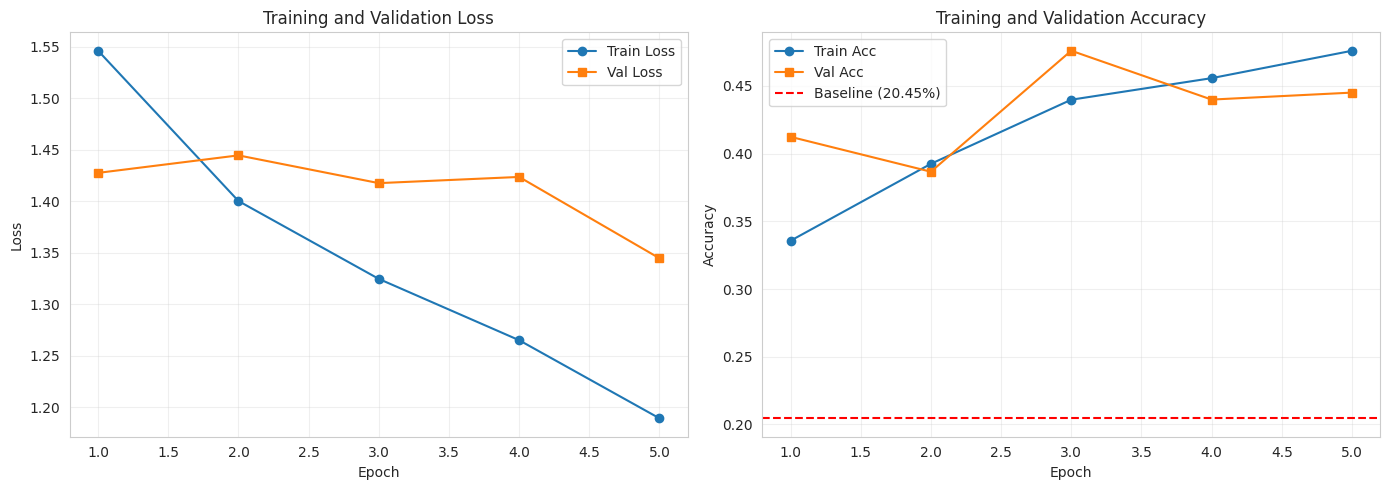


Loading best model for evaluation...


Evaluating Final Validation: 100%|██████████| 73/73 [00:08<00:00,  8.76it/s]



Classification Report (Validation):
              precision    recall  f1-score   support

     Class 1     1.0000    0.0769    0.1429        26
     Class 2     0.3448    0.3125    0.3279        64
     Class 3     0.3662    0.2047    0.2626       127
     Class 4     0.4400    0.4162    0.4278       185
     Class 5     0.5507    0.8444    0.6667       180

    accuracy                         0.4759       582
   macro avg     0.5403    0.3710    0.3656       582
weighted avg     0.4727    0.4759    0.4419       582



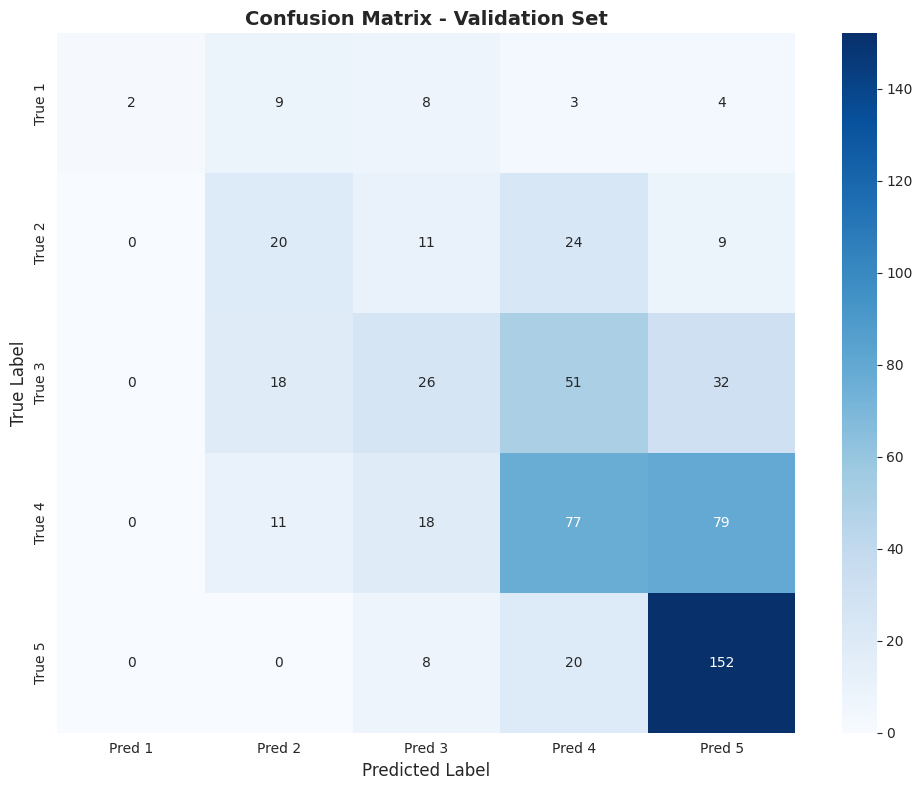


OBSERVATIONS:
1. Training still improving (51.64% train acc at epoch 3)
2. Val loss increased from epoch 1→2 but improved at epoch 3
3. Model needs more training or hyperparameter tuning


In [33]:
# %%
print("="*60)
print("ANALYZING TRAINING RESULTS")
print("="*60)

import matplotlib.pyplot as plt

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(range(1, NUM_EPOCHS+1), history['train_loss'], marker='o', label='Train Loss')
axes[0].plot(range(1, NUM_EPOCHS+1), history['val_loss'], marker='s', label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(range(1, NUM_EPOCHS+1), history['train_acc'], marker='o', label='Train Acc')
axes[1].plot(range(1, NUM_EPOCHS+1), history['val_acc'], marker='s', label='Val Acc')
axes[1].axhline(y=0.2045, color='r', linestyle='--', label='Baseline (20.45%)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Load best model for detailed evaluation
print("\nLoading best model for evaluation...")
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])

# Evaluate on validation set with detailed metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

val_loss, val_acc, val_preds, val_labels = evaluate(
    model, val_loader, criterion, device, "Final Validation", log_file
)

# Classification report
print("\nClassification Report (Validation):")
print(classification_report(
    val_labels,
    val_preds,
    target_names=[f'Class {i}' for i in range(1, 6)],
    digits=4
))

# Confusion matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Pred {i}' for i in range(1, 6)],
            yticklabels=[f'True {i}' for i in range(1, 6)])
plt.title('Confusion Matrix - Validation Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("OBSERVATIONS:")
print("="*60)
print(f"1. Training still improving (51.64% train acc at epoch 3)")
print(f"2. Val loss increased from epoch 1→2 but improved at epoch 3")
print(f"3. Model needs more training or hyperparameter tuning")